In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchvision.transforms import v2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda


In [2]:
#IMAGE VARIABLES
IMG_SIZE = 64 
BATCH_SIZE = 128
CHANNELS = 3
CLASSES = 10

#NETWORK VAR
SIZE_LATENT = 256
FEATURES_GEN = 64
FEATURES_DIS = 64

#testing variables
seed = 42
NUM_EPOCHS = 10000
LR = 0.0002
BETA1 = 0.5

PATH = '../data-students/TRAIN'

In [4]:
# Define Albumentations transforms
albumentations_transform = A.Compose([
    A.Rotate(limit=15, border_mode=cv2.BORDER_REFLECT, p=1.0),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=1.0),
    A.Perspective(scale=(0.05, 0.1), keep_size=True, pad_mode=cv2.BORDER_REFLECT, p=1.0),
    ToTensorV2()
])

# Define torchvision transforms
torchvision_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Combined transform class
class CombinedTransform:
    def __init__(self, albumentations_transform, torchvision_transform):
        self.albumentations_transform = albumentations_transform
        self.torchvision_transform = torchvision_transform

    def __call__(self, image):
        # Apply Albumentations transforms
        image = np.array(image)
        augmented = self.albumentations_transform(image=image)
        image = augmented['image']

        # Convert tensor to PIL Image for torchvision transforms
        image = transforms.ToPILImage()(image)

        # Apply torchvision transforms
        image = self.torchvision_transform(image)
        return image

# Use the combined transformation
combined_transform = CombinedTransform(albumentations_transform, torchvision_transform)

# Initial dataset for class identification
init_dataset = datasets.ImageFolder(root=PATH, transform=torchvision_transform)
classes = init_dataset.classes
print("Classes in dataset:", classes)

# Define how many times you want to enlarge the dataset
enlarge_factor = 3

# Create a list to hold the datasets
combined_datasets = [init_dataset]

# Add the transformed dataset to the list multiple times
for _ in range(enlarge_factor):
    transformed_dataset = datasets.ImageFolder(root=PATH, transform=combined_transform)
    combined_datasets.append(transformed_dataset)

# Concatenate the datasets into a single dataset
enlarged_dataset = ConcatDataset(combined_datasets)

# Create a dictionary to store DataLoaders for each class
class_data_loaders = {}
num_classes = len(classes)  # Ensure num_classes matches the actual number of classes

# Filter dataset and create DataLoaders for each class
for class_idx in range(num_classes):
    class_indices = [i for i, (_, label) in enumerate(enlarged_dataset) if label == class_idx]
    class_subset = Subset(enlarged_dataset, class_indices)
    class_data_loaders[class_idx] = DataLoader(class_subset, batch_size=BATCH_SIZE, shuffle=True)

print("Data loaders created for each class.")

/home/stefanotrenti/miniconda3/envs/AML-env/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Classes in dataset: ['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']
Data loaders created for each class.


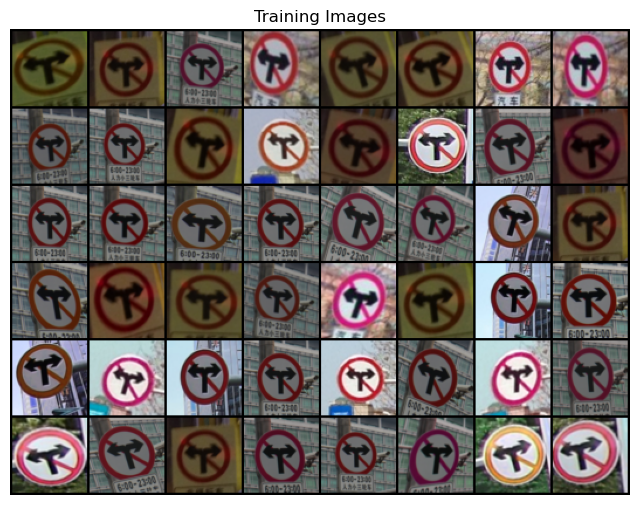

torch.Size([48, 3, 64, 64])
torch.Size([398, 530, 3])


In [5]:
 # Plot some training images
real_batch = next(iter(class_data_loaders[0]))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(SIZE_LATENT, FEATURES_GEN*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FEATURES_GEN*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN*8, FEATURES_GEN*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_GEN*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN*4, FEATURES_GEN*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_GEN*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN*2, FEATURES_GEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_GEN),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()  # Output is an image size: 3x64x64
        )

    def forward(self, input):
        #input = input.view(-1, self.latent_dim, 1, 1)
        return self.main(input)
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        dropout_prob=0.2
        
        self.model = nn.Sequential(
            
            nn.Conv2d(CHANNELS, FEATURES_DIS, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS, FEATURES_DIS*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_DIS*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS*2, FEATURES_DIS*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_DIS*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS*4, FEATURES_DIS*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_DIS*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1).squeeze(1)


class DCGAN(nn.Module):
    def __init__(self):
        super(DCGAN, self).__init__()
        self.Generator = Generator()
        self.Discriminator = Discriminator()
        self.losses_G = []
        self.losses_D = []

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
def random_zeros(labels, flip_probability):
    # Iterate over each value and flip with the specified probability
    for i in range(len(labels)):
        if random.random() < flip_probability:
            labels[i] = 0            

In [8]:
def train(model, criterion, train_loader, num_epochs = NUM_EPOCHS):
    img_list = []
    iters = 0
    real_label = 1.
    fake_label = 0.
    fixed_noise = torch.randn(64, SIZE_LATENT, 1, 1, device=device)
    
    model.Discriminator.apply(weights_init)
    model.Generator.apply(weights_init)
    
    model.Discriminator.train()
    model.Generator.train()
    
    optimizerG = optim.Adam(model.Generator.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD = optim.Adam(model.Discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))
    
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress"):
        for i, (real_data, _) in enumerate(train_loader, 0):
            
            #-----------train discriminator-----------
            model.Discriminator.zero_grad()
            real = real_data.to(device)
            b_size = real.size(0)            
            labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            random_zeros(labels, 0.05)#introduce randomness in the labels
            output_real = model.Discriminator(real).view(-1)#
            diss_loss_real = criterion(output_real, labels)
            diss_loss_real.backward()
            D_x = output_real.mean().item()
            
            #-----------train with the fake batch-----------
            noise = torch.randn(b_size, SIZE_LATENT, 1, 1, device=device)
            fake_images = model.Generator(noise)
            labels.fill_(fake_label)
            output_fake = model.Discriminator(fake_images.detach()).view(-1)
            diss_loss_fake = criterion(output_fake, labels)
            diss_loss_fake.backward()
            D_G_z1 = output_fake.mean().item()
            dis_loss = (diss_loss_real + diss_loss_fake) #/2
            optimizerD.step()
            
            #----------train generator-----------
            model.Generator.zero_grad()
            labels.fill_(real_label)
            output = model.Discriminator(fake_images).view(-1)
            gen_loss = criterion(output, labels)
            gen_loss.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Save Losses for plotting later
            model.losses_G.append(gen_loss.item())
            model.losses_D.append(dis_loss.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    fake = model.Generator(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
            
            if(iters % 10000 == 0):
                torch.save(model.state_dict(), 'models_DCGAN/dcgan_{iters}_ckpt.pth')
            
    return model, img_list

In [9]:
models = {}
images_lists = {}
criterion = nn.BCELoss()
model_path = '/models_DCGAN'
os.makedirs(model_path, exist_ok=True)


for class_idx in range(num_classes):#8, num_classes):
    model = DCGAN().to(device)
    models[class_idx], images_lists[class_idx] = train(model, criterion, class_data_loaders[class_idx], NUM_EPOCHS)
    model_path_ = os.path.join(model_path, f"model_DCGAN_{class_idx}.pth")
    torch.save(model.state_dict(), model_path_)

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]/home/stefanotrenti/miniconda3/envs/AML-env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]/home/stefanotrenti/miniconda3/envs/AML-env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.

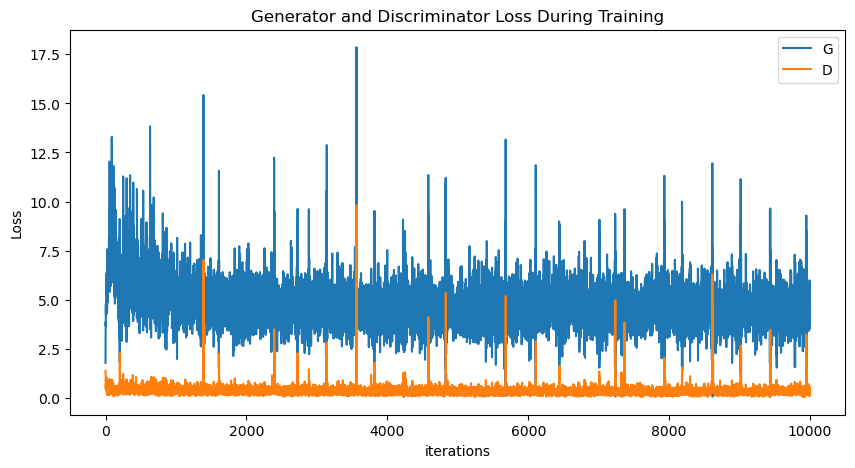

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(models[0].losses_G,label="G")
plt.plot(models[0].losses_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()